# Projet : Thème astral

In [1]:
import numpy as np
import pandas as pd
import math
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import deque

# Sommaire

1. Introduction
2. Modèle
3. Position des planètes
    1. Paramètres orbitaux
    2. Calcul de l'anomalie moyenne
    3. Résolution de l'équation de Kepler
    4. Position des planètes dans le repère cartésien
4. Calcul de l'ascendant
5. Calcul du signe solaire
6. Thème astral
    1. Signe dans lequel se trouve la planète 
    2. Affichage du thème astral
7. Conclusion
8. Bibliographie

# 1. Introduction

Dans ce projet, nous nous intéressons à l'élaboration d'un modèle numérique visant à représenter le thème astral d'une personne en fonction de sa date de naissance. Le thème astral est une représentation symbolique de la position des planètes et des étoiles au moment précis de la naissance d'une personne. Il est souvent utilisé en astrologie pour interpréter la personnalité, les traits de caractère et les événements futurs de cette personne. <br>Notre objectif est de développer un modèle basé sur les équations de Kepler, fondamentales en astronomie, pour calculer avec précision la position des planètes dans le système solaire à un instant donné, de relier ces positions au signe astrologique correspondant pour finalement générer un graphique du cercle du thème astral qui sera propre à chacun.
<br>En astrologie, chaque signe et chaque planète possède ses caractéritiques propres, et le thème astral est ce qui relie tout cela dans une représentation visuelle.

# 2. Modèle

Pour pouvoir constituer le thème astral, nous avons dans un premier temps besoin de la position dans l'espace des planètes voulues. Ici, celles qui nous intéressent sont la Terre, Vénus, Mercure et Mars.
<br>Nous considérons que nous nous trouvons dans l'espace à deux dimensions, et ainsi nous cherchons à obtenir la longitude et la latitude de chaque planète (en $°$), puis de les placer dans notre repère à coordonnées cartésiennes.
<br>Pour simplifier notre modèle, nous ne considérons que la force attractive du Soleil et négligeons les forces perturbatrices des autres planètes. Il s'agit donc d'une orbite elliptique dont le Soleil occupe un foyer.  
Nous avons également choisi de ne pas s'intéresser à la Lune puisqu'il aurait fallu considérer la force exercée par la Terre, ce qui n'aurait pas fonctionné avec cette hypothèse d'orbites képlériennes.

# 3. Position des planètes

## 3.A. Paramètres orbitaux

Pour pouvoir calculer la position des planètes, nous avons d'abord besoin de leurs paramètres orbitaux :   

- le demi-grand axe $a$  ($UA$)
   - Terre : $a = 1.000~~UA$
   - Venus : $a = 0.723~~UA$
   - Mercure : $a = 0.387~~UA$
   - Mars : $a = 1.524~~UA$   
   
- l'excentricité orbitale $e$  ($mesure~sans~unite$) : elle exprime l'écart de forme entre l'orbite et le cercle parfait dont l'excentricité est nulle
   - Terre : $e = 0.0167$
   - Vénus : $e = 0.0068$
   - Mercure : $e = 0.2056$
   - Mars : $e = 0.0934$
   

- la période de révolution $T~(années)$
   - Terre : $T = 365.26~années$
   - Vénus : $T = 224.7~années$
   - Mercure : $T = 87.97~années$
   - Mars : $T = 687~années$
   
   
- l'anomalie moyenne $M~(rad)$ : l'angle entre le périapse et la position d'un corps fictif parcourant une orbite circulaire synchrone avec le corps réel.
   - on a : $M = n\times(t-t_{0})$
      - avec $n = \dfrac{2\times \pi}{T}$ 

In [2]:
# Initialistation des paramètres orbitaux

planete = np.array(['Terre', 'Venus', 'Mercure', 'Mars'], dtype = str)
exc = np.array([0.0167, 0.0068, 0.2056, 0.0934]) #excentricité
sem = np.array([1.000, 0.723, 0.387, 1.524]) #demi-grand axe
T = [365.26, 224.7, 87.97, 687] #période
T0 = datetime(2000, 1, 1)  # époque de référence
M0 = 0

## 3.B. Calcul de l'anomalie moyenne

Comme dit plus haut, on a on a :  
<center>$M = n\times(t-t_{0})$   
<br>avec $n = \dfrac{2\times \pi}{T}$
<br></center>Ici, $t-t_{0}$ correspond au nombre de jours écoulés depuis l'époque de référence, c'est-à-dire le $1^{er}$ janvier 2000.    
<br>On calcule ensuite l'anomalie moyenne pour chaque planète (qui change puisque la période de révolution est différente) en fonction de la date de naissance.

## 3.C. Résolution de l'équation de Kepler

L'équation de Kepler en orbite elliptique est donnée par : 
<center> $E - e\times  sin(E) = M$

- $E$ l'anomalie excentrique ($rad$) : l'angle entre la direction du périapse et la position courante d'un objet sur son orbite

In [3]:
def kepler_equation(E, M, e):
    """Résout l'équation de Kepler pour trouver l'anomalie excentrique."""
    return E - e * math.sin(E) - M

#### Obtention de l'anomalie excentrique par la méthode de Newton-Raphson

Pour obtenir l'anamolie excentrique E à l'instant t, on calcule tout d'abord l'anomalie moyenne M. Il faut ensuite résoudre l'équation de Kepler, une équation non linéaire qui ne peut être résolue que de manière approchée.  
Nous avons donc utilisé la méthode de Newton-Raphson qui est un algorithme de recherche de zéro d’une fonction réelle par approximations linéaires successives.  
Pour cela, on définit la fonction suivante :  
<center> $g(E) = E - e\times sin(E) - M$  

<br></center>dont il s'agit de trouver la racine. Une première estimation de l'anomalie ecentrique est ${E_0}=M$  
Ensuite, avec la méthode de Newton-Raphson, on calcule une suite d'approximations ${E_i}$ qui converge vers la solution.  
Pour obtenir $E_{i+1}$ à partir de $E_{i}$, on calcule la dérivée $g'({E_i})$ et on trace l'intersection de la tangente en ${E_i}$ avec l'axe des abscisses. La nouvelle estimation est donc donnée par :   
    
<center>$E_{i+1} = {E_i} - \dfrac{g(E_{i})}{g'(E_{i})}$  
    
<br></center>En appliquant de manière récurrente cette relation, on obtient rapidement une estimation $E_{i}$ très proche de la solution. Une tolérance $\epsilon$ est choisie. Lorsque $|E_{i+1}-E_{i}|<\epsilon$, l'itération est stoppée.
    
 
Cette étape en particulier nous a posé plusieurs difficultés, d'abord pour la compréhension de la méthode mathématique puis pour la traduction en langage informatique.

In [4]:
def solve_kepler(M, e):
    """Utilise la méthode de Newton-Raphson pour résoudre l'équation de Kepler."""
    E0 = M  # Initial guess for E
    tolerance = 1e-8  # Tolerance for convergence
    max_iterations = 1000  # Maximum number of iterations
    iteration = 0
    while True:
        f = kepler_equation(E0, M, e)
        f_prime = 1 - e * math.cos(E0)
        E = E0 - f / f_prime
        if abs(E - E0) < tolerance or iteration >= max_iterations:
            break
        E0 = E
        iteration += 1
    return E

## 3.D. Position des planètes dans le repère cartésien

Une fois l'anomalie excentrique obtenue, on peut dorénavant placer nos planètes dans le repère cartésien. Cette position est donnée par la formule suivante :   
<br><center> $x = a(cosE - e)$
<br> $y = a\sqrt{1-e^{2}}sinE$
<br></center> Une fois ces positions obtenues, on a pu les placer dans notre repère à coordonnées cartésiennes dont l'origine est le soleil.
<br> Nous avons pris soin de mettre les axes des abscisses et ordonnées à la même échelle pour que le résultat soit cohérent visuellement et que les planètes qui sont plus ou moins éloignées du Soleil dans la réalité le soient aussi sur le graphique. Nous avons également défini une couleur pour chaque planètes afin de bien les différencier, ce qui était plus compliqué que prévu car les couleurs se chevauchaient. Nous avons finalement trouvé une solution en utilisant les fonctions `iter()` et `next()` qui nous ont permis de boucler sur les couleurs de la bonne manière.

In [5]:
def planet_position(a, e, E):
    """Calcule la position de la planète sur son orbite."""
    x = a * (math.cos(E) - e)
    y = a * math.sqrt(1 - e**2) * math.sin(E)
    return [x], [y]

In [6]:
def position(date_precise):
    #calcul de T0 et t
    delta_t = date_precise - T0
    T0_julian = 2451545.0
    t = T0_julian + delta_t.days + delta_t.seconds / 86400.0
    
    # Calculer l'anomalie moyenne à la date précise
    anom = np.array([])
    for i in T:
        n = 2*np.pi/i
        m = M0 + n * (delta_t.days)
        anom = np.append(anom,m)
    
    Ex = np.array([])
    for (M, e) in zip(anom, exc):
        ex = solve_kepler(M, e)
        Ex = np.append(Ex,ex)

    tab_x = np.array([])
    tab_y = np.array([])
    for (a, e, M, E, i) in zip(sem, exc, anom, Ex, planete):
        X = planet_position(a, e, E)[0]
        Y = planet_position(a, e, E)[1]
        tab_x = np.append(tab_x,X)
        tab_y = np.append(tab_y,Y)
        print("Position de la planète ", i, " :", X,Y)
    return tab_x, tab_y

In [7]:
annee = int(input("Entrez votre année de naissance : "))
mois = int(input("Entrez votre mois de naissance : "))
jour = int(input("Entrez votre jour de naissance : "))

X, Y = position(datetime(annee, mois, jour))

Entrez votre année de naissance :  2002
Entrez votre mois de naissance :  7
Entrez votre jour de naissance :  8


Position de la planète  Terre  : [-1.0118053653741625] [-0.09880581134602225]
Position de la planète  Venus  : [0.6043608106981687] [0.38923421572170125]
Position de la planète  Mercure  : [-0.45169116993437425] [0.10399707234993534]
Position de la planète  Mars  : [-1.036114629958248] [1.2290049972485433]


In [8]:
# Fonction pour calculer la trajectoire circulaire
def calculer_trajectoire_circulaire(x, y):
    rayon = np.sqrt(x**2 + y**2)
    angles = np.linspace(0, 2*np.pi, 100)
    x_traj = rayon * np.cos(angles)
    y_traj = rayon * np.sin(angles)
    return x_traj, y_traj

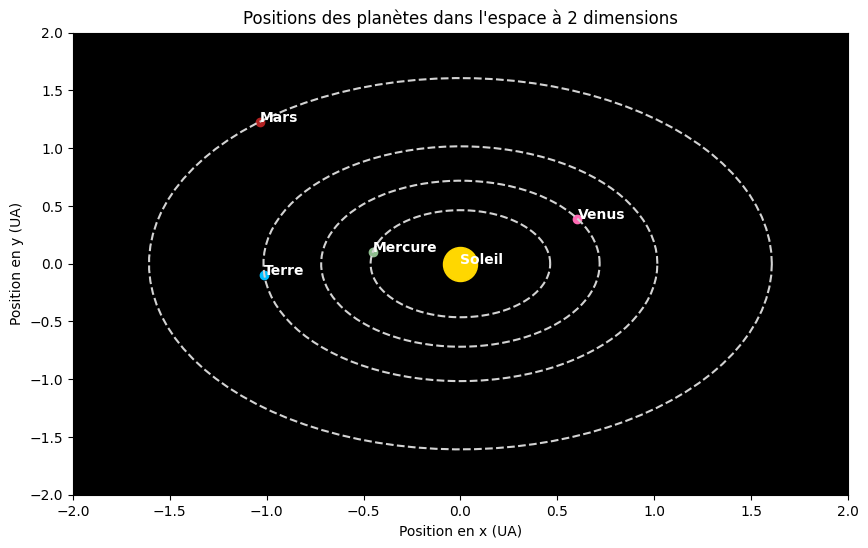

In [9]:
# Créer le graphique
couleur = iter(['deepskyblue', 'hotpink', 'darkseagreen', 'firebrick'])

plt.figure(figsize=(10, 6))

for i in range(4):
    plt.scatter(X[i], Y[i], color= next(couleur), marker='o')
    
#Soleil
plt.scatter(0,0, color='gold', s=600)
plt.text(0,0, 'Soleil', color='white', fontweight='bold')

# Trajectoires circulaires des planètes
for i in range(4):
    x_traj, y_traj = calculer_trajectoire_circulaire(X[i], Y[i])
    plt.plot(x_traj, y_traj, color='lightgray', linestyle='--')

    
    
# Ajouter des étiquettes pour les planètes
for i in range(4):
    plt.text(X[i], Y[i], planete[i], color='white', fontweight='bold')
    
# Définir les labels des axes
plt.xlabel('Position en x (UA)')
plt.ylabel('Position en y (UA)')
plt.title('Positions des planètes dans l\'espace à 2 dimensions')

# Afficher le graphique
plt.gca().set_axisbelow(True)
plt.gca().set_facecolor('black')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

# 4. Calcul de l'ascendant 

L'ascendant représente le signe zodiacal qui était à l'horizon à l'instant précis de la naissance, vu depuis le lieu de naissance.  
L'ascendant est essentiel dans la constitution du thème astral. En effet, chaque cercle de thème astral est unique, et le signe de l'ascendant définit l'endroit où le cercle "commence", c'est-à-dire qu'il sera situé tout à fait à gauche du cercle, et que les autres signes seront placés à la suite dans leur ordre classique.
<br>Ici, pour simplifier le calcul, nous ne considérons que Paris comme lieu de naissance. Ecrire un code qui aurait calculé l'ascendant pour tous les endroits du monde aurait été bien trop long et compliqué, car il aurait fallu rentrer toutes les coordonnées géographiques de chaque ville, c'est pourquoi nous avons choisi de nous limiter à Paris, dont nous connaissons les coordonnées géographiques.  
Pour calculer l'ascendant, il faut suivre plusieurs étapes : 
1. Calculer son heure sidérale, qui est une mesure du temps basée sur la rotation de la Terre par rapport aux étoiles fixes. Un jour sidéral est le temps nécessaire à la Terre pour effectuer une rotation complète par rapport aux étoiles fixes, et est légèrement plus court que le jour solaire.
2. Additionner son heure de naissance avec l'heure sidérale
3. Ajuster l'heure obtenue à l'étape précédente en fonction des conventions de mesure du temps en vigueur à l'époque de la naissance, comme par exemple l'instauration des fuseaux horaires et l'adoption de l'heure d'été dans certaines régions. 
4. Faire correspondre l'heure à un ascendant

In [10]:
# Paramètres de naissance
naissance = str(annee)+ '-' + str(mois) + '-' + str(jour)
heure_naissance = input("Entrez l'heure de naissance : ")
timezone_offset = 2  # Heure locale est UTC+1 (vous devrez ajuster ceci en fonction du fuseau horaire)
latitude = 48.8583  # Latitude de Paris
longitude = 2.2945   # Longitude de Paris

Entrez l'heure de naissance :  15:24:00


In [11]:
# Convertir la date de naissance en objet datetime
date_et_heure = datetime.strptime(naissance + ' ' + heure_naissance, '%Y-%m-%d %H:%M:%S')

In [12]:
# Fonction pour calculer le temps sidéral moyen (GMST)
def calculate_gmst(utc_time):
    # Calculer le jour julien
    jd = 367 * utc_time.year - 7 * ((utc_time.year + (utc_time.month + 9) // 12) // 4) + 275 * utc_time.month // 9 + utc_time.day + 1721013.5
    # Calculer la fraction du jour julien
    jd_frac = (utc_time.hour + (utc_time.minute + utc_time.second / 60) / 60) / 24
    # Calculer le nombre de jours depuis le 1er janvier 2000 (J2000.0)
    d = jd - 2451545.0
    # Calculer le temps sidéral moyen en heures
    gmst = 6.697374558 + 0.06570982441908 * d + 1.00273790935 * jd_frac
    # Normaliser le temps sidéral entre 0 et 24 heures
    gmst = gmst % 24
    return gmst

In [13]:
# Calculer le temps sidéral moyen (GMST)
gmst = calculate_gmst(date_et_heure)

def heure_ascendant (utc_time, sideral):
    temp = (utc_time.hour + (utc_time.minute + utc_time.second / 60) / 60) + sideral
    if utc_time.year > 1976:
        if utc_time.month > 3 and utc_time.month < 11:
            temp = temp -3
        else :
            temp = temp -1
    if temp > 24:
        temp = temp -24
    return temp

In [14]:
# Fonction pour convertir l'ascendant en signe astrologique
def _ascendant_(heure):
    if heure >= 17.98 and heure <= 18.97:
        return "Bélier"
    elif heure >= 18.98 and heure <= 20.28:
        return "Taureau"
    elif heure >= 20.29 and heure <= 22.13:
        return "Gémeaux"
    elif heure >= 22.14 and heure <= 0.55:
        return "Cancer"
    elif heure >= 0.56 and heure <= 3.27:
        return "Lion"
    elif heure >= 3.28 and heure <= 6.00:
        return "Vierge"
    elif heure >= 6.01 and heure <= 8.72:
        return "Balance"
    elif heure >= 8.73 and heure <= 11.42:
        return "Scorpion"
    elif heure >= 11.43 and heure <= 13.88:
        return "Sagittaire"
    elif heure >= 13.89 and heure <= 15.70:
        return "Capricorne"
    elif heure >= 15.71 and heure <= 17.00:
        return "Verseau"
    else:
        return "Poissons"

In [15]:
print('Votre ascendant est', _ascendant_(heure_ascendant(date_et_heure, gmst)))

Votre ascendant est Balance


En astrologie, l'ascendant agit comme un filtre à travers lequel la personnalité d'une personne est exprimée et perçue. Il influence la manière dont elle se présente au monde, son comportement et la première impression qu'elle laisse sur les autres. Souvent considéré comme un 'masque', l'ascendant reflète la façon dont une personne interagit avec le monde extérieur. 

# 5. Calcul du signe solaire

En astrologie, le signe solaire fait référence au signe du zodiaque dans lequel se trouvait le Soleil au moment de la naissance d'une personne. Les douze signes du zodiaque sont déterminés par la position apparente du Soleil par rapport aux constellations lors de la naissance.
<br>Le signe solaire est souvent considéré comme l'aspect le plus important du thème astrologique d'une personne. On lui attribue des traits de personnalité, des caractéristiques et des tendances générales qui sont supposés influencer la personne née sous ce signe.

Le calcul du signe solaire ne dépend que du jour de la naissance de la personne. 

In [16]:
def signe_sol(mois,jour):
    if (mois == 3 and jour >= 21) or (mois == 4 and jour <= 20):
        return "Bélier"
    elif (mois == 4 and jour >= 21) or (mois == 5 and jour <= 20):
        return "Taureau"
    elif (mois == 5 and jour >= 21) or (mois == 6 and jour <= 21):
        return "Gémeaux"
    elif (mois == 6 and jour >= 22) or (mois == 7 and jour <= 23):
        return "Cancer"
    elif (mois == 7 and jour >= 24) or (mois == 8 and jour <= 23):
        return "Lion"
    elif (mois == 8 and jour >= 24) or (mois == 9 and jour <= 23):
        return "Vierge"
    elif (mois == 9 and jour >= 24) or (mois == 10 and jour <= 23):
        return "Balance"
    elif (mois == 10 and jour >= 24) or (mois == 11 and jour <= 22):
        return "Scorpion"
    elif (mois == 11 and jour >= 23) or (mois == 12 and jour <= 20):
        return "Sagittaire"
    elif (mois == 12 and jour >= 21) or (mois == 1 and jour <= 20):
        return "Capricorne"
    elif (mois == 1 and jour >= 21) or (mois == 2 and jour <= 19):
        return "Verseau"
    else:
        return "Poissons"

In [17]:
print('Votre signe solaire est', signe_sol(mois,jour))

Votre signe solaire est Cancer


# 6. Thème astral

## 6.A. Signe dans lequel se trouve la planète

Chaque signe du zodiaque couvre un secteur de 30 degrés le long de l'écliptique, le chemin apparent du Soleil dans le ciel.
<br>Pour déterminer dans quel signe zodiacal se trouvait la planète au moment de la naissance, on utilise sa position le long de l'écliptique. Nous avons mesuré cette position en UA, et il faut dans un premier temps la convertir en degrés. En divisant la longitude de la planète par 30 et en prenant la partie entière du résultat, on obtient le numéro du signe du zodiaque dans lequel se situe la planète.

In [18]:
#convertir longitudes UA en degres
def deg(long, dist):
    return (long * 360)/dist

In [19]:
distance = [1, 0.7, 0.38, 1.5237]
degre = []

for (long,dist) in zip(X,distance):
    degre.append(deg(long, dist))

In [20]:
signe_traverse = []
_signes_ = ['Bélier', 'Taureau', 'Gémaux', 'Cancer', 'Lion', 'Vierge', 'Balance', 'Scorpion', 'Sagittaire', 'Capricorne', 'Verseau', 'Poisson']
for i in degre:
    signe_traverse.append(i//30)

In [21]:
for (j,l) in zip(signe_traverse, planete):
    j=j%12
    print('La planète ', l, 'est dans le signe du', _signes_[int(j)])

La planète  Terre est dans le signe du Poisson
La planète  Venus est dans le signe du Verseau
La planète  Mercure est dans le signe du Capricorne
La planète  Mars est dans le signe du Cancer


En astrologie, chaque planète est associé à un domaine. Le soleil avec l'ego, la Terre avec les émotions, Vénus avec l'amour, Mercure avec la communication et Mars avec l'action.
<br>Ainsi, chaque signe ayant ses caractéristiques propres, le thème astral sert donc à relier ces caractéristiques au domaine de la planète et c'est pourquoi il est considéré comme une carte de la personnalité d'une personne.

## 6.B. Affichage du thème astral

Comme expliqué plus haut, le cercle du thème astral est propre à chacun. Le positionnement des signes sur le cercle sera différent en fonction du signe de l'ascendant, qui sera toujours placé tout à fait à gauche sur le cercle. Les autres signes suivent alors dans l'ordre habituel.
<br>On se sert alors des positions des planètes dans les signes pour afficher le thème astral qui sera unique et propre à chacun.

In [22]:
clr = ['deepskyblue', 'hotpink', 'darkseagreen', 'firebrick']

In [23]:
def plot_theme_astral(ascendant_str):
    # Liste des signes du zodiaque dans l'ordre
    signes = ["Bélier", "Taureau", "Gémeaux", "Cancer", "Lion", "Vierge", "Balance", "Scorpion", "Sagittaire", "Capricorne", "Verseau", "Poisson"]
    
    #rotation
    signes.reverse()
    index=signes.index(ascendant_str)
    signes=deque(signes)
    signes.rotate(-index+3)
    signes=list(signes)
    
    # Trouver l'index de l'ascendant dans la liste des signes
    ascendant_index = signes.index(ascendant_str)
    
    # Création de la figure et des axes
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Déterminer l'angle de départ en fonction de l'ascendant
    start_angle = 360 / len(signes) * ascendant_index
    
    # Tracer le cercle du thème astral
    for i in range(len(signes)):
        angle = (start_angle + i * (360 / len(signes))) % 360  # Angle pour chaque signe
        ax.plot([np.cos(np.radians(angle)), np.cos(np.radians(angle + (360 / len(signes))))], [np.sin(np.radians(angle)), np.sin(np.radians(angle + (360 / len(signes))))], 'k-')  # Relier chaque signe au suivant
        if signes[i] == signe_sol(mois,jour):
            ax.text(1.2 * np.cos(np.radians(angle)), 1.2 * np.sin(np.radians(angle)), signes[i], ha='center', va='center')  # Affichage du nom de chaque signe
            ax.text(1.2 * np.cos(np.radians(angle)), 1.2 * np.sin(np.radians(angle)) - 0.1, 'Soleil', ha='center', va='center', fontweight='bold', color='gold')  
        elif signes[i] == ascendant_str:
            ax.text(1.2 * np.cos(np.radians(angle)), 1.2 * np.sin(np.radians(angle)), signes[i], ha='center', va='center')  # Affichage du nom de chaque signe
            ax.text(1.2 * np.cos(np.radians(angle)), 1.2 * np.sin(np.radians(angle)) - 0.1, 'Ascendant', ha='center', va='center', fontweight='bold', color='red')  
        for (j,l,p) in zip(signe_traverse, planete, clr):
            j=j%12
            if signes[i] ==  _signes_[int(j)]:
                ax.text(1.2 * np.cos(np.radians(angle)), 1.2 * np.sin(np.radians(angle)), signes[i], ha='center', va='center')  # Affichage du nom de chaque signe
                ax.text(1.2 * np.cos(np.radians(angle)), 1.2 * np.sin(np.radians(angle)) - 0.2, l , ha='center', va='center', fontweight='bold', color=p)  
            else:
                ax.text(1.2 * np.cos(np.radians(angle)), 1.2 * np.sin(np.radians(angle)), signes[i], ha='center', va='center')  # Affichage du nom de chaque signe
    
    # Affichage de l'ascendant
    ax.plot(-1, 0, 'ro', label=ascendant_str)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.axis('off')
    ax.text(0, 0, 'Thème astral', ha='center', va='center', fontsize=16, fontweight='bold', fontstyle='italic', color='lightcoral')
    plt.show()

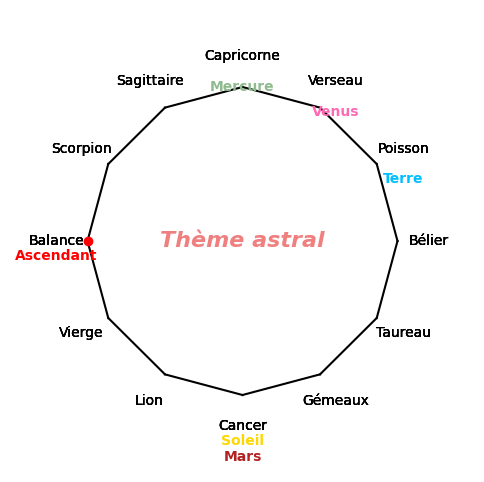

In [24]:
ascendant = _ascendant_(heure_ascendant(date_et_heure, gmst))
plot_theme_astral(ascendant)

# 7. Conclusion

En conclusion, bien que nous soyons conscientes que l'astrologie ne relève pas de la science, ce sujet de modélisation nous a permis d'aborder la position des planètes dans l'espace d'une manière originale et de donner à cela une signification via un sujet qui passionne depuis des générations, l'astrologie.
<br>Pour que nos résultats soient plus précis, il aurait fallu considérer également les forces exercées par les autres planètes et pas seulement celle du Soleil. Seulement, les équations de Kepler ne nous permettent pas cela.
<br>Bien que l'astrologie puisse être controversée, nous espérons que notre projet aura su susciter un intérêt ou au moins piqué la curiosité.

# 8. Bibliographie

paramètres orbitaux : https://fr.wikipedia.org/wiki/Mod%C3%A8le:Param%C3%A8tres_orbitaux_des_plan%C3%A8tes_et_plan%C3%A8tes_naines_du_Syst%C3%A8me_solaire

équations de Kepler :  https://fr.wikipedia.org/wiki/%C3%89quation_de_Kepler

équations de Kepler et méthode de Newton-Raphson : https://www.f-legrand.fr/scidoc/docmml/sciphys/meca/kepler/kepler.html

méthode de Newton-Raphson : http://revue.sesamath.net/spip.php?article1230#:~:text=La%20m%C3%A9thode%20de%20Newton%2DRaphson%20%5B1%5D%20est%20un%20proc%C3%A9d%C3%A9,sa%20courbe%20permettent%20d%27%C3%A9viter

calcul de l'ascendant : https://chris-semet.net/votre-astro-pratique/comment-calculer-votre-ascendant/

esthétique des graphiques : https://chat.openai.com/